In [1]:
import sys
import pickle
import seaborn as sns
import numpy as np
from numpy import mean
from numpy import std

import pandas as pd
from pandas.core.common import flatten

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Add parent directory to path to allow import of config.py
sys.path.append("..")

import config as conf

Second modeling strategy attempted will be a multiple linear model which predicts the next term's enrollment based on all of the previous term's data.

In [2]:
data = pd.read_csv(f'{conf.DATA_PATH}{conf.FORMATTED_DATAFILE}')

# Seperate independent & dependent variables
X = data.drop(conf.TARGET_VARIABLE, axis=1)
y = data[conf.TARGET_VARIABLE]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Census Enrollment                14 non-null     float64
 1   Census Fill Rate                 14 non-null     float64
 2   Count of Migrated Data           14 non-null     float64
 3   Current Enrollment               14 non-null     float64
 4   Current Fill Rate                14 non-null     float64
 5   Enrollment Capacity              14 non-null     float64
 6   Ftef                             14 non-null     float64
 7   Ftes                             14 non-null     float64
 8   Ftes/Ftef                        14 non-null     float64
 9   Number Retained                  14 non-null     float64
 10  Number Successful                14 non-null     float64
 11  Retention Rate                   14 non-null     float64
 12  Sec. Count              

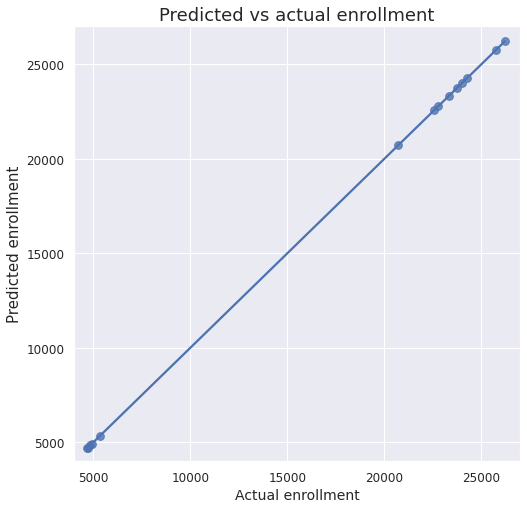

In [3]:
# Create and fit a LinearRegression object
lm = LinearRegression()
linear_model = lm.fit(X, y)

# Predict enrollment
predicted_enrollment = lm.predict(X)

# Grab actual enrollment numbers to compare with
actual_enrollment = y

# Plot actual enrollment vs predicted enrollment
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.regplot(y=predicted_enrollment, x=actual_enrollment, fit_reg=True, scatter_kws={'s':60})
ax.tick_params(labelsize=12)
ax.set_title('Predicted vs actual enrollment', fontsize=18)
ax.set_xlabel('Actual enrollment', fontsize=14)
ax.set_ylabel('Predicted enrollment', fontsize=15)
ax.set_xlim(4000, 27000)
ax.set_ylim(4000, 27000)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [4]:
# Score model
scikit_R_sqr = linear_model.score(X, actual_enrollment)
MAE = mean_absolute_error(y, predicted_enrollment)
print('SciKit-learn R\u00b2: {}'.format(np.round(scikit_R_sqr, 3)))
print(f'Mean absolute error: {int(MAE)}')

SciKit-learn R²: 1.0
Mean absolute error: 0


Looks too good to be true, right? Yes, it is - this is just over-fitting, plain and simple. We have no idea how well this model will generalize to new data and no reason to expect that it will at all. To do this right we need to split the data up into a training and test set so we can get an estimate of how our model will perform on unseen data.

In [5]:
# Split data randomly into training and testing sets
training_data = data.sample(frac=conf.TRAIN_TEST_SPLIT)
test_data = data.drop(training_data.index)

# Seperate dependent and independent variable
training_features = training_data.copy()
test_features = test_data.copy()

training_labels = training_features.pop(conf.TARGET_VARIABLE)
test_labels = test_features.pop(conf.TARGET_VARIABLE)

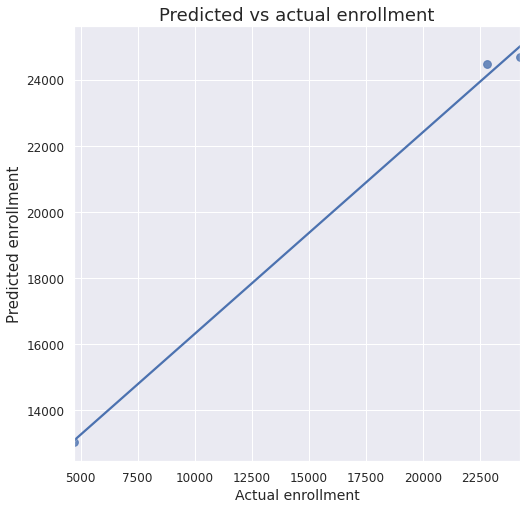

In [6]:
# Create and fit a LinearRegression object
lm = LinearRegression()
linear_model = lm.fit(training_features, training_labels)

# Predict enrollment
predicted_enrollment = lm.predict(test_features)

# Grab actual enrollment numbers to compare with
actual_enrollment = test_labels

# Plot actual enrollment vs predicted enrollment
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.regplot(
    y=predicted_enrollment, 
    x=actual_enrollment, 
    fit_reg=True, 
    ci=False, 
    scatter_kws={'s':60}
)

ax.tick_params(labelsize=12)
ax.set_title('Predicted vs actual enrollment', fontsize=18)
ax.set_xlabel('Actual enrollment', fontsize=14)
ax.set_ylabel('Predicted enrollment', fontsize=15)
# ax.set_xlim(4000, 27000)
# ax.set_ylim(4000, 27000)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [7]:
scikit_R_sqr = linear_model.score(test_features, actual_enrollment)
MAE = mean_absolute_error(test_labels, predicted_enrollment)
print('SciKit-learn R\u00b2: {}'.format(np.round(scikit_R_sqr, 3)))
print(f'Mean absolute error: {int(MAE)}')

SciKit-learn R²: 0.693
Mean absolute error: 3491


Ouch! Now it looks terrible... and we see the problem. With this small of a dataset we 'memorize' the training set just fine, but the model does not generalize to unseen data at all.

Let's see if we can improve using bootstrap aggregation - the plan will be to train multiple models on multiple randomly chosen subsets of the data and then use the resulting ensemble of models to make predictions. First step is to encapsulate the above operations into functions so we can easily repeat them inside of a loop.

In [8]:
def create_datasets(data, training_data_fraction, label_column_name):
    '''Takes master data as pandas dataframe splits into train and
    test features and labels, returns a dict of dataframes'''
    
    # Split data randomly into training and testing sets
    training_data = data.sample(frac=training_data_fraction)
    test_data = data.drop(training_data.index)

    # Seperate dependent and independent variable
    training_features = training_data.copy()
    test_features = test_data.copy()

    training_labels = training_features.pop(label_column_name)
    test_labels = test_features.pop(label_column_name)
    
    dataset = {}
    dataset['training_features'] = training_features
    dataset['test_features'] = test_features
    dataset['training_labels'] = training_labels
    dataset['test_labels'] = test_labels
    
    return dataset

In [9]:
def fit_linear_model(data):
    '''Takes dataset dict, returns fit linear model'''
    
    # Create and fit a LinearRegression object
    lm = LinearRegression()
    linear_model = lm.fit(dataset['training_features'], dataset['training_labels'])
    
    return lm

In [10]:
# First make some empty lists to hold our trained models and other results
results = {}
results['trained_linear_models'] = []
results['test_scores'] = []
results['test_labels'] = []
results['test_features'] = []
results['test_predictions'] = []

# Outer training loop
for i in range(conf.N_MODELS):
    print(f'Training model {i}', end='\r')
    
    # Make dataset
    dataset = create_datasets(
        data,
        conf.TRAIN_TEST_SPLIT,
        conf.TARGET_VARIABLE
    )
    
    # Fit the model to the training portion of the dataset
    linear_model = fit_linear_model(dataset)
    
    # Use the trained model to make predictions from the test set features
    predictions = linear_model.predict(test_features)
    
    test_score = mean_absolute_error(dataset['test_labels'], predictions)
    
    # Sanity check model score
    if test_score < 1000000:
        # Store results
        results['trained_linear_models'].append(linear_model)

        # Add test set score to list
        results['test_scores'].append(test_score)

        # Add test set predictions and labels to list
        results['test_predictions'].extend(list(flatten(predictions)))
        results['test_labels'].extend(dataset['test_labels'])

Cool - now we have a ensemble of models which were each fit on a randomly chosen test/train split of the data - we also have a distribution of test set scores. Lets plot it and take a look at how we are faring. 

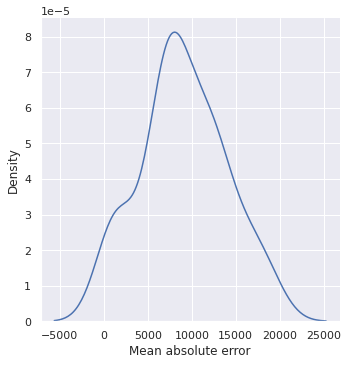

In [11]:
# Plot distribution of MAE scores from each model
sns.displot(results['test_scores'], kind="kde")
plt.xlabel('Mean absolute error')

plt.show()

In [12]:
print(f'Avg test set MAE: {int(mean(results["test_scores"]))}')

Avg test set MAE: 9057


Not that great to be honest - but at least now we have some idea of the error distribution. For example - if we had stuck with the one-off model and gotten lucky on the test/train split, we could have ended up with near zero MAE and thought we had a crystal ball on our hands, only to be badly disapointed in our predictions when next semester rolled arround.

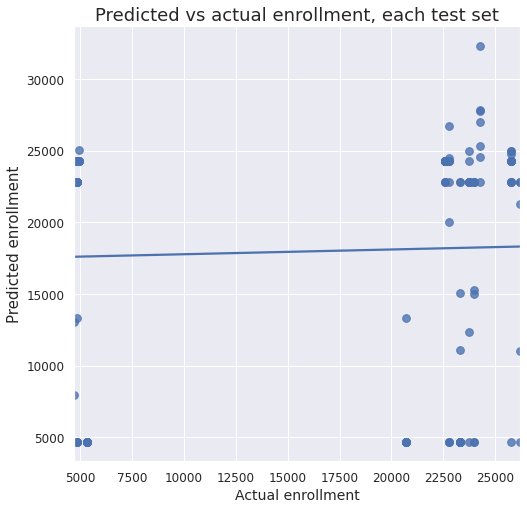

In [13]:
# Plot actual enrollment vs predicted enrollment
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.regplot(
    y=results['test_predictions'], 
    x=results['test_labels'], 
    fit_reg=True, 
    ci=True, 
    scatter_kws={'s':60}
)

ax.tick_params(labelsize=12)
ax.set_title('Predicted vs actual enrollment, each test set', fontsize=18)
ax.set_xlabel('Actual enrollment', fontsize=14)
ax.set_ylabel('Predicted enrollment', fontsize=15)
# ax.set_xlim(3000, 27000)
# ax.set_ylim(3000, 27000)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [14]:
# Split master data into features and labels
X = data.drop(conf.TARGET_VARIABLE, axis=1)
y = data[conf.TARGET_VARIABLE]

# Empty list to hold predictions
predictions = []

for linear_model in results['trained_linear_models']:
    predicted_enrollment = linear_model.predict(X)
    predictions.append(predicted_enrollment)

# Average the predictions from each model
predicted_enrollment = np.mean(np.array(predictions), axis=0)

In [16]:
results['ensamble_predictions'] = predicted_enrollment
results['labels'] = y

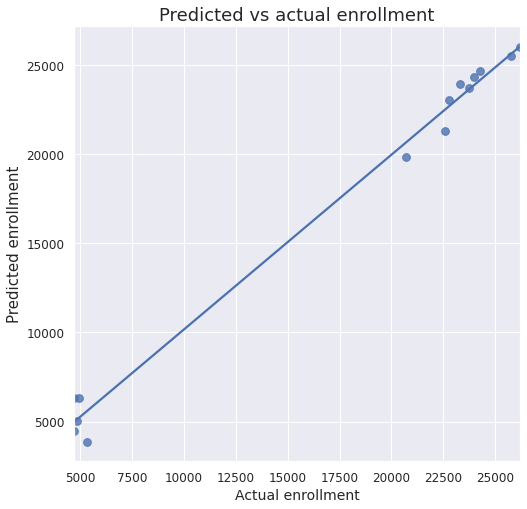

In [17]:
# Grab actual enrollment numbers to compare with
actual_enrollment = y

# Plot actual enrollment vs predicted enrollment
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.regplot(
    y=predicted_enrollment, 
    x=actual_enrollment, 
    fit_reg=True, 
    ci=False, 
    scatter_kws={'s':60}
)

ax.tick_params(labelsize=12)
ax.set_title('Predicted vs actual enrollment', fontsize=18)
ax.set_xlabel('Actual enrollment', fontsize=14)
ax.set_ylabel('Predicted enrollment', fontsize=15)
# ax.set_xlim(4000, 27000)
# ax.set_ylim(4000, 27000)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Just for completeness, lets set up to construct a confidence interval arround our predictions using our model ensemble.

In [18]:
# Pick one semester to predict
single_semester = data.iloc[5]

# Seperate independent & dependent variables
X = single_semester.drop(conf.TARGET_VARIABLE)
X = np.array(X).reshape(1, -1)

y = single_semester[conf.TARGET_VARIABLE]

# Empty list to hold predictions
predictions = []

# Make prediction with each model
for linear_model in results['trained_linear_models']:
    predicted_enrollment = linear_model.predict(X)
    predictions.extend(predicted_enrollment)


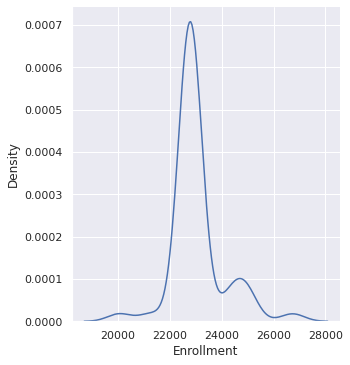

In [19]:
# Plot distribution of predictions from each model
sns.displot(predictions, kind="kde")
plt.xlabel('Enrollment')

plt.show()

In [20]:
import scipy.stats as st

mean = np.mean(predictions)
low, high = st.norm.interval(alpha=0.95, loc=np.mean(predictions), scale=st.sem(predictions))

print(f'Mean: {int(mean)}, 95% CI: {int(low)}-{int(high)}')
print(f'True value: {int(y)}')

Mean: 23039, 95% CI: 22766-23312
True value: 22781


In [21]:
# Save trained model ensemble
pkl_filename = f'{conf.RESULTS_PATH}{conf.MULTIPLE_LINEAR_MODEL_RESULTS_FILE}'

with open(pkl_filename, 'wb') as file:
    pickle.dump(results, file)